In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [2]:
import os
datafolder=r'D:\Ameyem\python\ML\Data\SeismicImage\SynthImages/'

noisefolder=datafolder+'noise/'
cleanfolder=datafolder+'clean/'
# noisefiles=os.listdir(noisefolder)
destfolder=datafolder+'/TrainingData'
# cleanfiles=os.listdir(cleanfolder)
# noisefiles

In [4]:
import os
import numpy as np
import shutil

# # Creating Train / Val / Test folders (One time use)

cleanfolder=datafolder+'clean/'
noisefolder=datafolder+'noise/'

os.makedirs(destfolder +'/train/noise' )
os.makedirs(destfolder +'/train/clean' )
os.makedirs(destfolder +'/test/noise' )
os.makedirs(destfolder +'/test/clean' )
os.makedirs(destfolder +'/val/noise' )
os.makedirs(destfolder +'/val/clean' )

In [7]:


# Creating partitions of the data after shuffeling
# currentCls = posCls
src = cleanfolder # Folder to copy images from
nsrc = noisefolder # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])
train_FileNames, val_FileNames, test_FileNames

# train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
# val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
# test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

# ntrain_FileNames = [nsrc+'/'+ name for name in train_FileNames.tolist()]
# nval_FileNames = [nsrc+'/' + name for name in val_FileNames.tolist()]
# ntest_FileNames = [nsrc+'/' + name for name in test_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(src+'/'+ name, destfolder +'/train/clean')
    shutil.copy(nsrc+'/'+ name, destfolder +'/train/noise')

for name in val_FileNames:
    shutil.copy(src+'/'+ name, destfolder +'/val/clean')
    shutil.copy(nsrc+'/'+ name, destfolder +'/val/noise')

for name in test_FileNames:
    shutil.copy(src+'/'+ name, destfolder +'/test/clean')
    shutil.copy(nsrc+'/'+ name, destfolder +'/test/noise')

Total images:  309
Training:  216
Validation:  46
Testing:  47


In [3]:
from PIL import Image
def getrandomCrops(imfile,cleanfolder,noisefolder,input_imsize=(320,320),nims=4):
    cimg = Image.open(cleanfolder+imfile)
    nimg = Image.open(noisefolder+imfile)
    cimg=cimg.convert('L')
    nimg=nimg.convert('L')
    width, height = cimg.size
    cleanimages=[]
    noiseimages=[]
    
    for i in range(nims):
        # Setting the points for cropped image
        left = np.random.randint(0,width-input_imsize[0])
        top = np.random.randint(0,height-input_imsize[1])
        right = left+input_imsize[0]
        bottom = top++input_imsize[1]

        # Cropped image of above dimension
        # (It will not change original image)
#         
        
#         print(cimg.crop((left, top, right, bottom)).size,np.array(cimg.crop((left, top, right, bottom))).shape)
        cleanimages.append(np.array(cimg.crop((left, top, right, bottom))))
#         print(cleanimages[-1].shape)
        
        noiseimages.append(np.array(nimg.crop((left, top, right, bottom))))
    return cleanimages,noiseimages

def DataGenerator(cleanfiles,cleanfolder,noisefolder,input_imsize=(540,540),numberofims=10):
    
    files=np.random.choice(cleanfiles,numberofims)
    cleanimages=[]
    noiseimages=[]
    for f in files:
        c,n=getrandomCrops(f,cleanfolder,noisefolder,input_imsize=input_imsize,nims=4)
#         print(np.array(c).shape)
        cleanimages.extend(c)
        noiseimages.extend(n)
#     print(np.array(cleanimages).shape)
    return np.array(cleanimages).astype('float32').reshape(len(cleanimages),*input_imsize,1) / 255., \
            np.array(noiseimages).astype('float32').reshape(len(cleanimages),*input_imsize,1) / 255. 

In [4]:
# runs=20
# trcleanfolder,trnoisefolder=destfolder +'/train/clean',destfolder +'/train/noise'
# trcleanfiles=os.listdir(trcleanfolder)
# valcleanfolder,valnoisefolder=destfolder +'/val/clean',destfolder +'/val/noise'
# valcleanfiles=os.listdir(valcleanfolder)
# for i in range(runs):
#     print('Runn333333333333333333333333333#################### ',i)
    
#     train_clean_ims,train_noise_ims=DataGenerator(trcleanfiles,trcleanfolder,trnoisefolder,numberofims=10)
#     val_clean_ims,val_noise_ims=DataGenerator(valcleanfiles,valcleanfolder,valnoisefolder,numberofims=3)

In [7]:
input_imsize=(540,540)
def model():
    input_layer = Input(shape=(*input_imsize, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 540, 540, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 540, 540, 128)     1280      
                                                                 
 conv2d_8 (Conv2D)           (None, 540, 540, 64)      73792     
                                                                 
 conv2d_9 (Conv2D)           (None, 540, 540, 16)      9232      
                                                                 
 batch_normalization_2 (Batc  (None, 540, 540, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 270, 270, 16)     0         
 2D)                                                       

In [8]:
# input_imsize=(540,540)
# def model():
#     input_layer = Input(shape=(*input_imsize, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
#     # encoding
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)

#     x = MaxPooling2D((2, 2), padding='same')(x)
    
#     x = Dropout(0.5)(x)

#     # decoding
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)

#     x = UpSampling2D((2, 2))(x)

#     output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
#     model = Model(inputs=[input_layer], outputs=[output_layer])
#     model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

#     return model


# model = model()
# model.summary()

In [13]:
runs=20
trcleanfolder,trnoisefolder=destfolder +'/train/clean//',destfolder +'/train/noise//'
trcleanfiles=os.listdir(trcleanfolder)
valcleanfolder,valnoisefolder=destfolder +'/val/clean//',destfolder +'/val/noise//'
valcleanfiles=os.listdir(valcleanfolder)
histories=[]
callback = EarlyStopping(monitor='loss', patience=3)
for i in range(runs):
    print('Run########################################### ',i)
    
    train_clean_ims,train_noise_ims=DataGenerator(trcleanfiles,trcleanfolder,trnoisefolder,input_imsize=input_imsize,numberofims=60)
    print('tran im calc done')
    val_clean_ims,val_noise_ims=DataGenerator(valcleanfiles,valcleanfolder,valnoisefolder,input_imsize=input_imsize,numberofims=18)    
    print('val im calc done')
    history = model.fit(train_noise_ims,train_clean_ims, validation_data = (val_noise_ims,val_clean_ims), \
                        epochs=2, batch_size=8, verbose=1, callbacks=[callback])
    histories.append(history)

Run###########################################  0
tran im calc done
val im calc done
Epoch 1/2
30/30 [==============================] - 103s 3s/step - loss: 0.0265 - mae: 0.0807 - val_loss: 0.0662 - val_mae: 0.1956
Epoch 2/2
30/30 [==============================] - 116s 4s/step - loss: 0.0225 - mae: 0.0757 - val_loss: 0.0730 - val_mae: 0.1737
Run###########################################  1
tran im calc done
val im calc done
Epoch 1/2
30/30 [==============================] - 118s 4s/step - loss: 0.0208 - mae: 0.0694 - val_loss: 0.0785 - val_mae: 0.1784
Epoch 2/2
30/30 [==============================] - 124s 4s/step - loss: 0.0185 - mae: 0.0662 - val_loss: 0.0711 - val_mae: 0.1653
Run###########################################  2
tran im calc done
val im calc done
Epoch 1/2
30/30 [==============================] - 120s 4s/step - loss: 0.0400 - mae: 0.0964 - val_loss: 0.0681 - val_mae: 0.1385
Epoch 2/2
30/30 [==============================] - 124s 4s/step - loss: 0.0301 - mae: 0.0867 - 

In [30]:
# model.save(datafolder+'model_540_128_64_16.h5')
datafolder

'D:\\Ameyem\\python\\ML\\Data\\SeismicImage\\SynthImages/'

In [17]:
runs=20
trcleanfolder,trnoisefolder=destfolder +'/train/clean//',destfolder +'/train/noise//'
trcleanfiles=os.listdir(trcleanfolder)
valcleanfolder,valnoisefolder=destfolder +'/val/clean//',destfolder +'/val/noise//'
valcleanfiles=os.listdir(valcleanfolder)
# histories=[]
callback = EarlyStopping(monitor='loss', patience=3)
for i in range(runs):
    print('Run########################################### ',i)
    
    train_clean_ims,train_noise_ims=DataGenerator(trcleanfiles,trcleanfolder,trnoisefolder,input_imsize=input_imsize,numberofims=60)
    print('tran im calc done')
    val_clean_ims,val_noise_ims=DataGenerator(valcleanfiles,valcleanfolder,valnoisefolder,input_imsize=input_imsize,numberofims=18)    
    print('val im calc done')
    history = model.fit(train_noise_ims,train_clean_ims, validation_data = (val_noise_ims,val_clean_ims), \
                        epochs=3, batch_size=8, verbose=1, callbacks=[callback])
    histories.append(history)
    if i%5==0: model.save(datafolder+'model_540_128_64_16_{}.h5'.format(i))

Run###########################################  0
tran im calc done
val im calc done
Epoch 1/3
30/30 [==============================] - 93s 3s/step - loss: 0.0190 - mae: 0.0641 - val_loss: 0.0378 - val_mae: 0.0862
Epoch 2/3
30/30 [==============================] - 99s 3s/step - loss: 0.0171 - mae: 0.0611 - val_loss: 0.0313 - val_mae: 0.0731
Epoch 3/3
30/30 [==============================] - 113s 4s/step - loss: 0.0159 - mae: 0.0585 - val_loss: 0.0303 - val_mae: 0.0703
Run###########################################  1
tran im calc done
val im calc done
Epoch 1/3
30/30 [==============================] - 73s 2s/step - loss: 0.0184 - mae: 0.0617 - val_loss: 0.0290 - val_mae: 0.0724
Epoch 2/3
30/30 [==============================] - 72s 2s/step - loss: 0.0168 - mae: 0.0597 - val_loss: 0.0293 - val_mae: 0.0732
Epoch 3/3
30/30 [==============================] - 103s 3s/step - loss: 0.0159 - mae: 0.0581 - val_loss: 0.0214 - val_mae: 0.0615
Run###########################################  2
tran

In [32]:
# model.save(datafolder+'model_540_128_64_16_{}.h5'.format(i))
i

4

In [24]:
# histories.append(history)
train_clean_ims.shape
# history.history['loss']
for history in histories:
    # Check how loss & mae went down
    epoch_loss.extend( history.history['loss'])
    epoch_val_loss.extend( history.history['val_loss'])
    epoch_mae.extend( history.history['mae'])
    epoch_val_mae.extend( history.history['val_mae'])

[0.00945656094700098,
 0.00843754317611456,
 0.009215251542627811,
 0.00839256402105093,
 0.007989469915628433,
 0.008000647649168968,
 0.007957418449223042,
 0.009400257840752602,
 0.008155962452292442,
 0.00756900804117322]

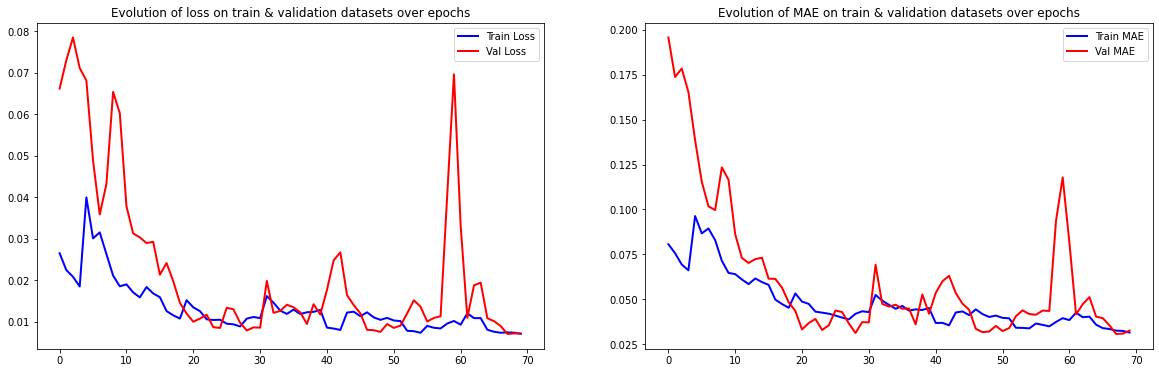

In [23]:
# Check how loss & mae went down
epoch_loss = []
epoch_val_loss = []
epoch_mae = []
epoch_val_mae = []
for history in histories:
    # Check how loss & mae went down
    epoch_loss.extend( history.history['loss'])
    epoch_val_loss.extend( history.history['val_loss'])
    epoch_mae.extend( history.history['mae'])
    epoch_val_mae.extend( history.history['val_mae'])

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [25]:
# epoch_val_mae
# for histrory in histories:
#     print()

In [30]:
model.save(datafolder+'model_540.h5')

In [26]:
testcleanfolder,testnoisefolder=destfolder +'/test/clean//',destfolder +'/test/noise//'
testcleanfiles=os.listdir(testcleanfolder)
test_clean_ims,test_noise_ims=DataGenerator(testcleanfiles,testcleanfolder,testnoisefolder,input_imsize=input_imsize,numberofims=5)


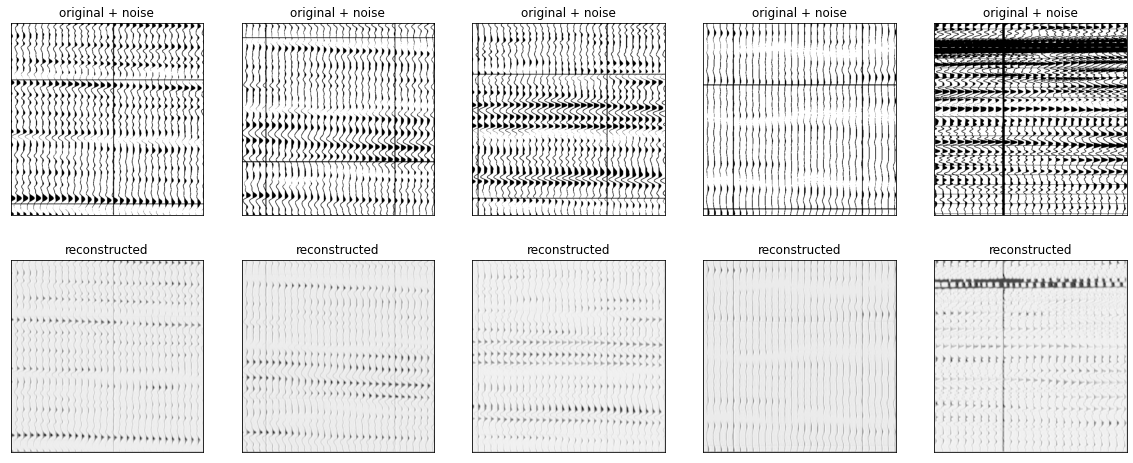

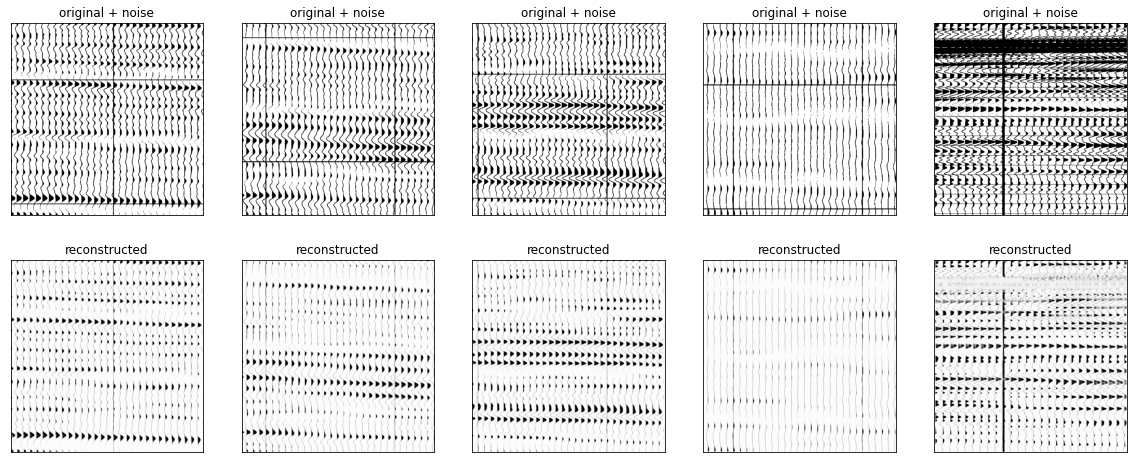

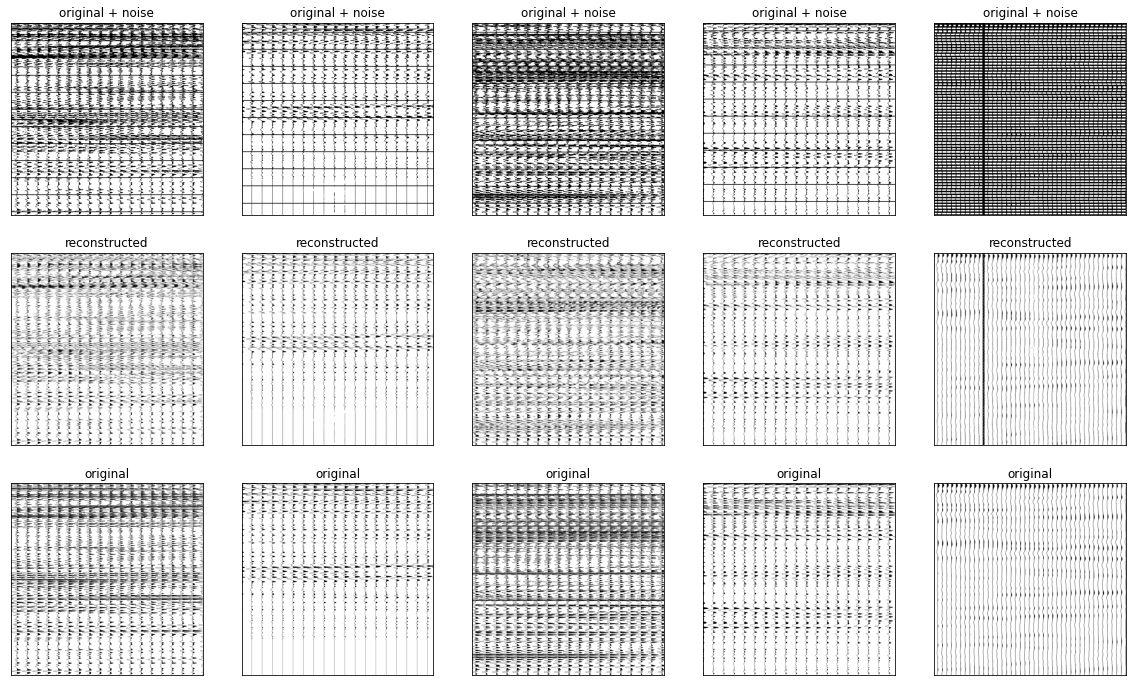

In [29]:
import tensorflow as tf
decoded_imgs = model.predict(test_noise_ims)

n = 5
plt.figure(figsize=(20, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(test_noise_ims[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(test_clean_ims[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()